# With top 5 features

## Imports <a id="Imports"></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import pipeline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import neighbors
from xgboost import XGBClassifier

#from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# remove warning
#import warnings
#warnings.filterwarnings("ignore")


In [2]:
def threshhold_and_plot(y_test, target, n_points=50, plot=True):
    """
    :param y_test: binary vector of actual targets
    :param target: vector of probabilities
    :param n_points: number of points to evaluate for a threshold
    :param plot: Boolean; whether or not to plot the results
    :return: vector of values of precision, recall, F1 for given points
    """
    # plot the value of the metric against the threshold
    #plt.figure(figsize=(12,12))
    probs = np.linspace(0, 1, n_points)
    def make_thresh():  # try n_points = 50 or 100...
        # calculate each metric here
        precision = [metrics.precision_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
                     for thresh in probs]
        recall = [metrics.recall_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
                  for thresh in probs]
        f1 = [metrics.f1_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
              for thresh in probs]
        roc_auc = [metrics.roc_auc_score(y_test,np.where(target > thresh,1,0))
                   for thresh in probs]
       
        return precision, recall, f1, roc_auc

    precision, recall, f1, roc_auc = make_thresh()

    
    if plot:
        plt.plot(probs, precision, label='precision')
        plt.plot(probs, recall, label='recall')
        plt.plot(probs, f1, label='f1')
        plt.plot(probs, roc_auc, label="roc auc")
        # plt.plot(probs, pr_auc, label="pr auc")
        plt.title("Metrics at various thresholds");
        plt.xlabel("Probability");
        plt.legend();
        return precision, recall, f1, roc_auc
    else:
        return precision, recall, f1, roc_auc

def max_thresh(score_vec):
  # can either unpack a tuple or feed in iterable by itself
    max_idx = np.argmax(score_vec)
    max_score = score_vec[max_idx]
    return max_idx, max_score

In [3]:
#plot roc
def plot_roc(actuals,preds):
    fpr, tpr, thresholds = metrics.roc_curve(actuals, preds)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()
    return fpr, tpr, thresholds

In [4]:
#plot precision recall curve
def plot_precision_recall_curve(actual,preds):
    precision,recall,Threshold = metrics.precision_recall_curve(y_true = actual,probas_pred=preds) 
    fig,ax=plt.subplots(figsize=(5,5))
    ax.plot(Threshold,precision[1:],label = 'Precision')
    ax.plot(Threshold,recall[1:],label = 'Recall')
    ax.set_xlabel('threshold')
    ax.set_ylabel('precision,recall')
    ax.set_title('RF: precision-recall')
    ax.hlines(y=0.5,xmin=0,xmax=1,color='red')
    ax.legend()
    ax.grid()

In [5]:
def plot_Confusionmatrix(actuals,target):
    plt.figure(figsize=(5,4))
    ConfMatrix = metrics.confusion_matrix(actuals,target, labels=[0,1], normalize='true')
    
    sns.heatmap(ConfMatrix,annot=True, cmap="Blues", 
                xticklabels = ["Staying","Attrited"], 
                yticklabels = ["Staying","Attrited"])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix");
    return

#### Data Reading

In [6]:
#Read the data
X_train = pd.read_csv("../data/4.X_train.csv")
y_train = pd.read_csv("../data/4.y_train.csv")
X_test = pd.read_csv("../data/4.X_test.csv")
y_test = pd.read_csv("../data/4.y_test.csv")

In [7]:
X_train.shape,y_train.shape

((7088, 16), (7088, 1))

In [8]:
X_test.shape,y_test.shape

((3039, 16), (3039, 1))

In [9]:
X_train.columns

Index(['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Gender_Encoded',
       'Dependent_count', 'Education_Level_sorted', 'Income_Category_sorted',
       'Card_Category_sorted', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
       'Marital_Status_sorted_Married', 'Marital_Status_sorted_Single'],
      dtype='object')

In [10]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,7088.0,-3.454018e-16,1.000071,-2.531322,-0.661337,-0.038008,0.709986,3.327966
Credit_Limit,7088.0,8.597793e+00,0.930669,7.271217,7.841395,8.418587,9.298671,10.449178
Total_Revolving_Bal,7088.0,9.103482e-01,0.638103,0.000000,0.248822,1.000000,1.396112,1.977219
Total_Trans_Amt,7088.0,8.167921e+00,0.656979,6.390241,7.674617,8.267449,8.468633,9.824661
Avg_Utilization_Ratio,7088.0,2.753070e-01,0.276635,0.000000,0.023000,0.175000,0.502000,0.999000
Gender_Encoded,7088.0,5.328725e-01,0.498953,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,7088.0,2.344949e+00,1.299597,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,7088.0,2.839306e+00,1.215114,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,7088.0,2.175226e+00,1.334986,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,7088.0,1.081546e+00,0.330233,1.000000,1.000000,1.000000,1.000000,4.000000


In [11]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,3039.0,1.760867e-16,1.000165,-2.545475,-0.671517,-0.046864,0.702719,2.701607
Credit_Limit,3039.0,8.616519e+00,0.940983,7.271217,7.854381,8.432724,9.328701,10.449178
Total_Revolving_Bal,3039.0,9.134881e-01,0.640117,0.000000,0.349961,1.000000,1.401403,1.961808
Total_Trans_Amt,3039.0,8.157574e+00,0.648578,6.234411,7.682021,8.271293,8.453401,9.797849
Avg_Utilization_Ratio,3039.0,2.739293e-01,0.273522,0.000000,0.022500,0.177000,0.503500,0.994000
Gender_Encoded,3039.0,5.202369e-01,0.499673,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,3039.0,2.349128e+00,1.297511,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,3039.0,2.851925e+00,1.201185,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,3039.0,2.199079e+00,1.332057,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,3039.0,1.088516e+00,0.341929,1.000000,1.000000,1.000000,1.000000,4.000000


## Training and Modeling <a id=Training_and_Modeling ></a>

### Model Selection 

Four competing supervised classfication models/algorithms are considered, namely, 
* Logistic Regression classification
* Random Forest classifier
* KNeighbours classification
* XGBoost classifier 

### Evaluation Metrics

Thinking of customers will not exit but he does, this means income loss for the Bank. Banks need to take action steps for this scenario. This is true +ve, and is "recall". Banks are looking for recall to be maximized, greater the recall lesser the chances of false negative means lesser chances of predicting customers will not exit where in reality they do. Since classes in the data are unbalanced, I can make use of the confusion matrix to examine the outcome of the model. Recall and precision metrics can be calculated from the confusion matrix, and this would help me assess the models.
This project aims to predict potential churn customers, and it is realized that the client cost of mistakenly classifying non-churn customers as churn may be high in practice because banks would not want to lose valuable customers, and the banks would like to identify churners at their best efforts as well. Thus, it would be useful to consider Recall. To complement this Receiver Operating Characteristic curve (ROC) is used. ROC is a plot of True Positive Rate (TPR) against False Positive Rate (FPR). This means I can consider TPR and FPR simultaneously, by making use of the area under the curve (AUC) of ROC.

TPR or Recall or Sensitivity tells us what proportion of the positive class got correctly classified. TPR = TP/(TP+FN)

FPR tells us what proportion of the negative class got incorrectly classified by the classifier. FPR = FP/(TN+FP)

All models are used to predict the actual class of the data point by predicting its probability of belonging to different classes. This gives us more control over the result.And ROC_AUC threshold is used to interpret the result of the classifier.


## Training and Modeling

### Hyperparameter Tuning and Model Training

Each model is subject to various hyperparameters that need to be determined. Here random search and grid search methods are used optimise the hyperparameters for our chosen models. Grid search exhaustively checks every combinations of hyperparameters given in the parameter domain to optimise the given score, "roc_auc" in this project. Random search checks random combinations of hyperparameters for a given number of iterations to optimise the given score. The advantage of random search is shorter time but the trade-off is that it might miss the best possible combination.

Below are the two functions, rand_search(), and grid_search(), to help in implementation. No scaling is done as it is each feature is already scaled, so then train the models with training dataset.

<b>Random Search</b> Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain.

<b>Grid Search</b> Define a search space as a grid of hyperparameter values and evaluate every position in the grid.


In [12]:
# rand search function
def rand_search(X_train,y_train,parameters,model,n_iter=100):
    #pipeline
    clf_pipeline = Pipeline([("clf",model)])
    #Grid search CV
    scoring = 'roc_auc'
    verbose = 1
    clf_rand = model_selection.RandomizedSearchCV(clf_pipeline, parameters, n_iter = n_iter,scoring=scoring,verbose = verbose, random_state=1,n_jobs=-1)
    #Learn from training
    clf_rand.fit(X_train,y_train)  #learn the training set
    
    print("Best parameters for ", model) 
    print(clf_rand.best_params_)
    print(f"\nBest train %s score: {clf_rand.best_score_ :.2f}" % (scoring))
    return clf_rand.best_estimator_

In [13]:
# grid search function
def grid_search(X_train,y_train,parameters,model):
    
    #pipeline
    clf_pipeline = Pipeline([("clf",model)])   #Pipeline applies scaling and model estimator
    #Grid search CV
    scoring = 'roc_auc'
    verbose = 1
    clf_grid = model_selection.GridSearchCV(clf_pipeline, parameters,  scoring=scoring,verbose = verbose)
    #Learn from training
    clf_grid.fit(X_train,y_train) 

    print("Best parameters for ", model) 
    print(clf_grid.best_params_)
    print(f"\nBest train %s score: {clf_grid.best_score_ :.2f}" % (scoring))
    return clf_grid.best_estimator_

### Logistic Regression

Logistic Regression is one of the simplest algorithms which estimates the relationship between one dependent binary variable and independent variables, computing the probability of occurrence of an event. The regulation parameter C controls the trade-off between increasing complexity (overfitting) and keeping the model simple (underfitting). For large values of C, the power of regulation is reduced and the model increases its complexity, thus overfitting the data.

The parameter ‘C’ was tuned using GridSearchCV( ) for the different datasets: original, standardized and with most important features. Once the parameter ‘C’ was defined for each dataset, the logistic regression model initiated and then fitted to the training data, as it was described in the methodology.

In this package, there are several hyperparameters that I need to pay attention to:

  C: controls the strength of regularisation penalty <br />
  solver: algorithms used for optimisation <br />
  class_weight: weights associated with classes <br />

In [14]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().ravel()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().ravel()

In [15]:
cross_validator = (
  model_selection.StratifiedShuffleSplit(train_size=0.8,
                                          random_state=1337,
                                          n_splits=50))

In [16]:
#Setting ranges for each hyperparameter.
log_params = {"clf__solver": ["lbfgs", "sag"],
               "clf__C": np.arange(0.1,2,0.1), 
               "clf__class_weight": ["balanced", None]
              }

In [17]:
%%time
classifier_lg = linear_model.LogisticRegression(fit_intercept= True,max_iter=500,random_state=632966)
log_best_estimator = grid_search(X_train,y_train, log_params,classifier_lg)

Fitting 5 folds for each of 76 candidates, totalling 380 fits
Best parameters for  LogisticRegression(max_iter=500, random_state=632966)
{'clf__C': 0.2, 'clf__class_weight': None, 'clf__solver': 'sag'}

Best train roc_auc score: 0.83
Wall time: 1min 15s


In [18]:
print(log_best_estimator)

Pipeline(steps=[('clf',
                 LogisticRegression(C=0.2, max_iter=500, random_state=632966,
                                    solver='sag'))])


### Random Forest Classification

Random Forest consists of an ensemble of decision trees. The algorithm splits the dataset into independent random subsamples and selects subsamples of features, and fits a decision tree classfier to each subsample. It then averages the estimates to improve the prediction accuracy.

I am using the class sklearn.ensemble.RandomForestClassifier from scikit learn. Based on our research, there are several hyperparameters that we will need to adjust:

n_estimator: the number of trees in the forest
min_samples_split:the minimum number of data points required to be at a leaf node
max_features: the number of features to consider when looking for the best split
max_depth: the maximum depth of the tree


In [19]:
#Setting ranges for each parameter.
clf__max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
rfc_params = {"clf__n_estimators": np.linspace(start = 100, stop = 1000, num = 10,dtype=int),
              "clf__min_samples_split": np.arange(2,6), 
              "clf__max_features":["sqrt", "log2"],
              "clf__max_depth": clf__max_depth
             }

In [20]:
%%time
classifier_rfc=ensemble.RandomForestClassifier(random_state=1,n_jobs=-1)
rfc_best_estimator = rand_search(X_train,y_train, rfc_params, classifier_rfc,n_iter=120) #apply random search

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  RandomForestClassifier(n_jobs=-1, random_state=1)
{'clf__n_estimators': 1000, 'clf__min_samples_split': 2, 'clf__max_features': 'log2', 'clf__max_depth': 30}

Best train roc_auc score: 0.96
Wall time: 8min 8s


### KNeighbours Classification

KNeighbours classfication chooses K nearest data points to the unlabeled data point then ask the K neighbours to "vote" for the classes that the point belongs to.

I am using the class sklearn.neighbors.KNeighborsClassifier for the implementation. Important hyperparameters that I will adjust are shown as follows:

n_neighbors: the number of closest neigbours
weights: weight function in prediction
p: Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2


In [21]:
#Setting ranges for the hyperparameters are shown below.
knn_params = {"clf__n_neighbors":[2,5,10,87,100],
              "clf__weights":["uniform", "distance"],
              "clf__p":[1,2] 
             }

In [22]:
%time
classifier_knn = neighbors.KNeighborsClassifier(n_jobs=-1)
knn_best_estimator = grid_search(X_train,y_train, knn_params, classifier_knn)

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for  KNeighborsClassifier(n_jobs=-1)
{'clf__n_neighbors': 100, 'clf__p': 1, 'clf__weights': 'distance'}

Best train roc_auc score: 0.89


### XGBoost Classification

XGBoost uses gradient boosting technique, and is on the priciples of decison tree ensemble, which a set of classification and regression trees. It is similar to Random Forest difference is how the algorithms train the models.

The hyperparameters those need to fine-tune are as follows:

learning_rate: the learning rate of gradient boosting
max_depth:maximum tree depth
min_child_weight: minimum sum of instance weight(hessian) needed in a child. Useful to reduce overfitting
reg_lambda: L2 regularisation


In [23]:
#Settingranges for the hyperparameter are shown below.
xgb_params = {"clf__learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               "clf__max_depth": np.arange(2,7),
               "clf__min_child_weight": np.arange(1,11),
               "clf__reg_lambda": np.linspace(0.1,1,num=10)
              }

In [24]:
%%time
classifier_xgb = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)

xgb_best_estimator = rand_search(X_train,y_train, xgb_params,classifier_xgb,n_iter=120)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
{'clf__reg_lambda': 0.4, 'clf__min_child_weight': 2, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}

Best train roc_auc score: 0.97
Wall time: 1min 20s


In [25]:
%%time
cv_scores_xgb = (
  model_selection.cross_val_score(xgb_best_estimator,
                                  X_train,
                                  y_train,
                                  scoring="roc_auc",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 8.85 s


### With top 5 Features Train and Predict

In [26]:
# loading only 8 above features to data frame
cols = ['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Gender_Encoded',
       'Dependent_count', 'Education_Level_sorted', 'Income_Category_sorted',
       'Card_Category_sorted', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
       'Marital_Status_sorted_Married', 'Marital_Status_sorted_Single']
 

X_train = pd.DataFrame(X_train,columns=cols)
X_test = pd.DataFrame(X_test,columns=cols)

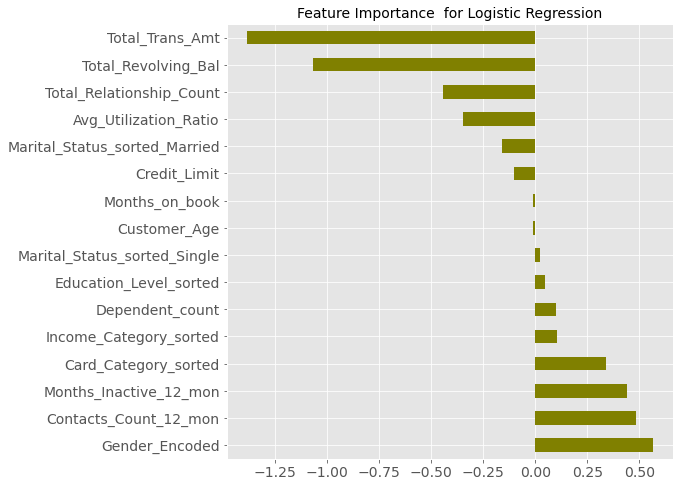

In [27]:
#Logistic Regression
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.title('Feature Importance  for Logistic Regression', fontsize=14)
feat_importances = pd.Series(log_best_estimator.named_steps["clf"].coef_.tolist()[0], index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize=14,color="olive")
plt.show()

For Logistic Regression top 5 features are 
'Total_Trans_Amt','Total_Revolving_Bal','Total_Relationship_Count','Avg_Utilization_Ratio','Marital_Status_sorted_Married'

In [28]:
cols = ['Total_Trans_Amt','Total_Revolving_Bal','Total_Relationship_Count','Avg_Utilization_Ratio','Marital_Status_sorted_Married']
X_train_lg = pd.DataFrame(X_train,columns=cols)
X_test_lg = pd.DataFrame(X_test,columns=cols)

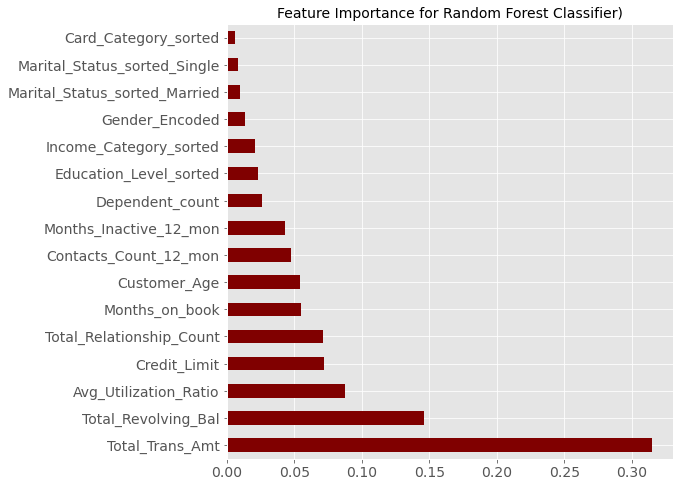

In [29]:
#Random Forest
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.title('Feature Importance for Random Forest Classifier)', fontsize=14)
feat_importances = pd.Series(rfc_best_estimator.named_steps["clf"].feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize = 14,color ='maroon')
plt.show()

For Random Forest top important features are -
'Total_Trans_Amt','Total_Revolving_Bal','Avg_Utilization_Ratio','Credit_Limit','Total_Relationship_Count'

In [30]:
cols = 'Total_Trans_Amt','Total_Revolving_Bal','Avg_Utilization_Ratio','Credit_Limit','Total_Relationship_Count'
X_train_rfc = pd.DataFrame(X_train,columns=cols)
X_test_rfc = pd.DataFrame(X_test,columns=cols)

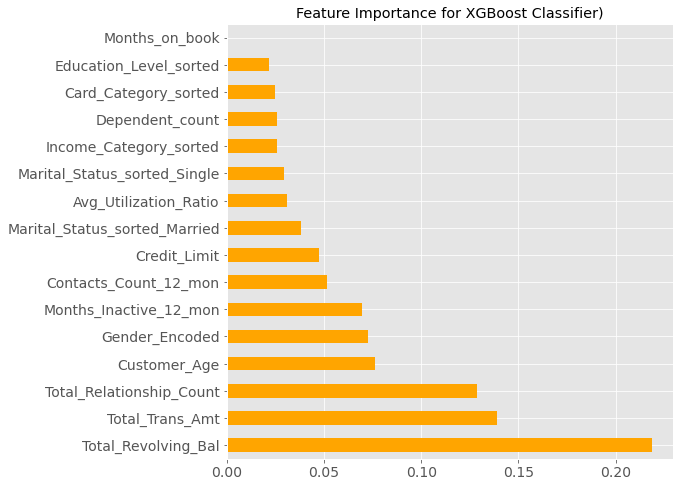

In [31]:
#XB Boost
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.title('Feature Importance for XGBoost Classifier)')
feat_importances = pd.Series(xgb_best_estimator.named_steps["clf"].feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize=14,color='orange')
plt.show()

For XGBoost top 5 important features are -
'Total_Revolving_Bal','Total_Trans_Amt','Total_Relationship_Count','Customer_Age','Gender_Encoded'

In [32]:
cols = 'Total_Revolving_Bal','Total_Trans_Amt','Total_Relationship_Count','Customer_Age','Gender_Encoded'
X_train_xgb = pd.DataFrame(X_train,columns=cols)
X_test_xgb = pd.DataFrame(X_test,columns=cols)

In [33]:
#KNN does not come with feature importance, using Xgboost top 5 fetaures
X_train_knn = X_train_xgb
X_test_knn = X_test_xgb

### Logistic Regression

In [34]:
X_train_lg = X_train_lg.to_numpy()
y_train_lg = y_train.copy()
X_test_lg = X_test_lg.to_numpy()
y_test_lg = y_test.copy()

### Get threshold using train set

In [35]:
#fit with 5 features
log_best_estimator = grid_search(X_train_lg,y_train_lg, log_params,classifier_lg)

Fitting 5 folds for each of 76 candidates, totalling 380 fits
Best parameters for  LogisticRegression(max_iter=500, random_state=632966)
{'clf__C': 1.8000000000000003, 'clf__class_weight': None, 'clf__solver': 'lbfgs'}

Best train roc_auc score: 0.79


In [36]:
y_proba_lg = log_best_estimator.predict_proba(X_train_lg)
y_proba_lg = y_proba_lg[:,1]

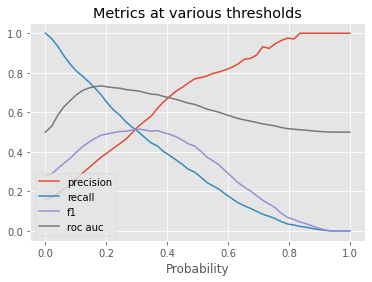

In [37]:
lg_prec, lg_rec, lg_f1, lg_roc_auc = threshhold_and_plot(y_train_lg,y_proba_lg)

In [38]:
lg_thresh_idx, lg_max_score = max_thresh(lg_roc_auc)
#print(f'max_roc_auc is: {lg_max_score :.4f}')
print(f'max_roc_auc is: {lg_max_score}')

max_roc_auc is: 0.7336200254106054


### Apply threshold on train set

In [39]:
lg_train_labels = np.where(y_proba_lg >= lg_max_score, 1, 0)

LG classification report on train set
               precision    recall  f1-score   support

     Staying       0.85      1.00      0.92      5949
    Attrited       0.92      0.07      0.14      1139

    accuracy                           0.85      7088
   macro avg       0.89      0.54      0.53      7088
weighted avg       0.86      0.85      0.79      7088



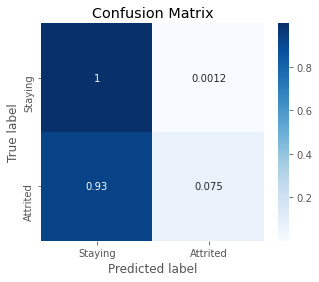

In [40]:
plot_Confusionmatrix(y_train,lg_train_labels)
y_class_report = metrics.classification_report(y_train_lg,lg_train_labels,zero_division=1, target_names=["Staying","Attrited"])
print("LG classification report on train set\n", y_class_report )

### Apply threshold on test set

In [41]:
lg_test_predict = log_best_estimator.predict_proba(X_test_lg)

In [42]:
lg_test_labels = np.where(lg_test_predict[:,1] >= lg_max_score, 1, 0)

In [43]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_test,lg_test_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

LG classification report on test set
               precision    recall  f1-score   support

     Staying       0.85      1.00      0.92      2551
    Attrited       1.00      0.07      0.13       488

    accuracy                           0.85      3039
   macro avg       0.92      0.53      0.52      3039
weighted avg       0.87      0.85      0.79      3039



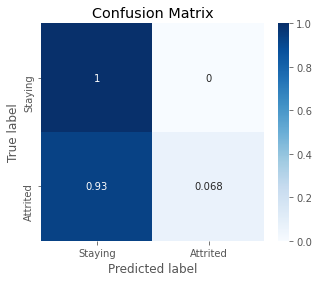

In [44]:
plot_Confusionmatrix(y_test,lg_test_labels)
y_class_report = metrics.classification_report(y_test_lg,lg_test_labels,zero_division=1, target_names=["Staying","Attrited"])
print("LG classification report on test set\n", y_class_report )

### Evaluation

This model is generalized better on train set and test set.However roc_AUC score 0.75, means it can 75% chance of identifying default and non-default class.Recall perfect for defaults, precision is 0.85. only. Indicating this model can not predict the defaults correctly, but non-deaults are predicted as defaults. Meaning those who are actually attrited are predicted as existing. However it is better than naive model.Can identity majority class much better, but still not to the expectation.

### Random Forest Classification

In [45]:
X_train_rfc = X_train_rfc.to_numpy()
y_train_rfc = y_train.copy()
X_test_rfc = X_test_rfc.to_numpy()
y_test_rfc = y_test.copy()

In [46]:
#fit with 5 features
rfc_best_estimator = rand_search(X_train_rfc,y_train_rfc, rfc_params, classifier_rfc,n_iter=120) #apply random search

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  RandomForestClassifier(n_jobs=-1, random_state=1)
{'clf__n_estimators': 900, 'clf__min_samples_split': 4, 'clf__max_features': 'log2', 'clf__max_depth': 10}

Best train roc_auc score: 0.95


### Get threshold using train set

In [47]:
y_proba_rfc = rfc_best_estimator.predict_proba(X_train_rfc)
y_proba_rfc = y_proba_rfc[:,1]

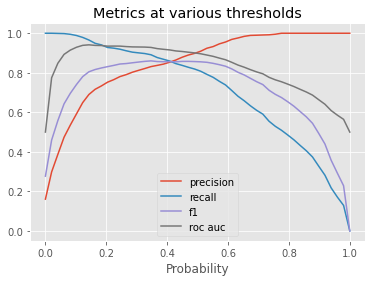

In [48]:
rfc_prec, rfc_rec, rfc_f1, rfc_roc_auc = threshhold_and_plot(y_train_rfc,y_proba_rfc)

In [49]:
rfc_thresh_idx, rfc_max_score = max_thresh(rfc_roc_auc)
print(f'max_roc_auc is: {rfc_max_score}')

max_roc_auc is: 0.9413601359285859


### Apply threshold on train set

In [50]:
rfc_train_labels = np.where(y_proba_rfc >= rfc_max_score, 1, 0)

In [51]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_train,rfc_train_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

RF classification report on train set
               precision    recall  f1-score   support

     Staying       0.87      1.00      0.93      5949
    Attrited       1.00      0.21      0.35      1139

    accuracy                           0.87      7088
   macro avg       0.93      0.60      0.64      7088
weighted avg       0.89      0.87      0.84      7088



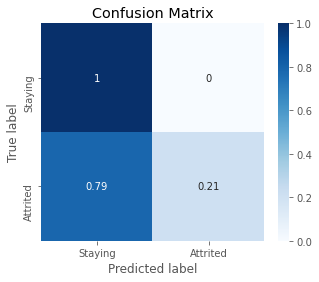

In [52]:
plot_Confusionmatrix(y_train,rfc_train_labels)
y_class_report = metrics.classification_report(y_train_rfc,rfc_train_labels,zero_division=1, target_names=["Staying","Attrited"])
print("RF classification report on train set\n", y_class_report )

### Apply threshold on test set

In [53]:
rfc_test_predict = rfc_best_estimator.predict_proba(X_test_rfc)

In [54]:
rfc_test_labels = np.where(rfc_test_predict[:,1] >= rfc_max_score, 1, 0)

In [55]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_test,rfc_test_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

RF classification report on test set
               precision    recall  f1-score   support

     Staying       0.86      1.00      0.92      2551
    Attrited       1.00      0.14      0.24       488

    accuracy                           0.86      3039
   macro avg       0.93      0.57      0.58      3039
weighted avg       0.88      0.86      0.81      3039



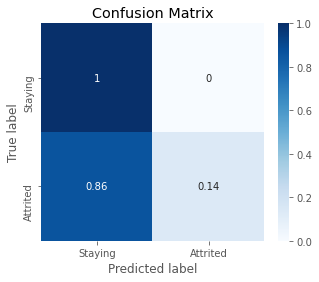

In [56]:
plot_Confusionmatrix(y_test,rfc_test_labels)
y_class_report = metrics.classification_report(y_test_rfc,rfc_test_labels,zero_division=1, target_names=["Staying","Attrited"])
print("RF classification report on test set\n", y_class_report )

### Evaluation

This model performed poorly in comparing to logistic regression. Same as naive model.
Grid search may yield better results with hypertuning params, can also try feature imporatnce and apply top 3 or 5 features to get better results. 
Though recall is 1, +ve predictive rate  precision is 0.84. Indicating 84% chance of correct prediction on defaults to non-defaults. 

For Hyper param tuning, I used random search,looks did not play the role, it is same as naive model.MAy try with Gridsearch.

### KNeighbours Classification

In [57]:
X_train_knn = X_train_knn.to_numpy()
y_train_knn = y_train.copy()
X_test_knn = X_test_knn.to_numpy()
y_test_knn = y_test.copy()

### Get threshold using train set

In [58]:
%%time
#Fit the model with 5 features
knn_best_estimator = grid_search(X_train_knn,y_train_knn, knn_params, classifier_knn)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for  KNeighborsClassifier(n_jobs=-1)
{'clf__n_neighbors': 87, 'clf__p': 1, 'clf__weights': 'distance'}

Best train roc_auc score: 0.91
Wall time: 3.35 s


In [59]:
y_proba_knn = knn_best_estimator.predict_proba(X_train_knn)
y_proba_knn = y_proba_knn[:,1]

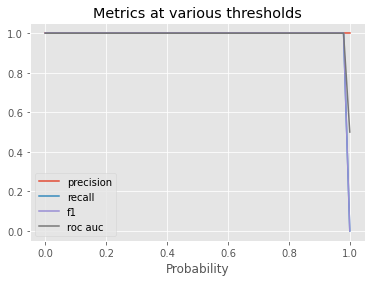

In [60]:
kn_prec, kn_rec, kn_f1, kn_roc_auc = threshhold_and_plot(y_train_knn,y_proba_knn)

In [61]:
%%time
cv_scores_knn = (
  model_selection.cross_val_score(knn_best_estimator,
                                  X_train,
                                  y_train,
                                  scoring="roc_auc",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 3.9 s


In [62]:
cv_quantiles = np.quantile(a=cv_scores_knn,q=[0.025,0.975])
print(f" Performance on training set is in range between {cv_quantiles[0]:.3f} to {cv_quantiles[1]:.3f},with average roc_auc:{cv_scores_knn.mean():.3f}")

 Performance on training set is in range between 0.863 to 0.909,with average roc_auc:0.889


<AxesSubplot:ylabel='Count'>

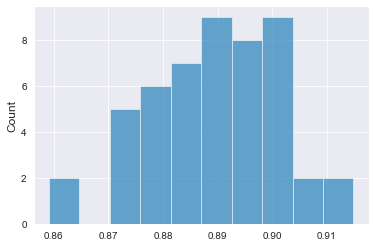

In [63]:
sns.set_style("darkgrid")
sns.histplot(cv_scores_knn, bins=10)

In [64]:
kn_thresh_idx, kn_max_score = max_thresh(kn_roc_auc)
print(f'max_roc_auc is: {kn_max_score}')

max_roc_auc is: 1.0


In [65]:
knn_train_labels = np.where(y_proba_knn >= kn_max_score, 1, 0)

In [66]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_train,lg_train_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

KN classification report on train set
               precision    recall  f1-score   support

     Staying       1.00      1.00      1.00      5949
    Attrited       1.00      1.00      1.00      1139

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088



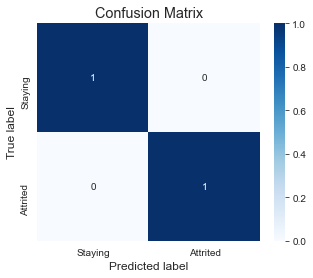

In [67]:
plot_Confusionmatrix(y_train,knn_train_labels)
y_class_report = metrics.classification_report(y_train_knn,knn_train_labels,zero_division=1, target_names=["Staying","Attrited"])
print("KN classification report on train set\n", y_class_report )

### Apply threshold on test set

In [68]:
knn_test_predict = knn_best_estimator.predict_proba(X_test_knn)

In [69]:
knn_test_labels = np.where(knn_test_predict[:,1] >= kn_max_score, 1, 0)

In [70]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_test,lg_test_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

classification report
               precision    recall  f1-score   support

     Staying       0.84      1.00      0.91      2551
    Attrited       1.00      0.00      0.00       488

    accuracy                           0.84      3039
   macro avg       0.92      0.50      0.46      3039
weighted avg       0.87      0.84      0.77      3039



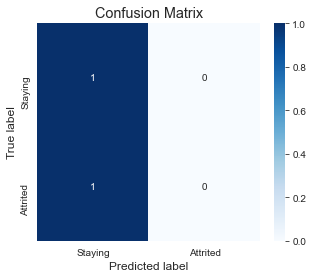

In [71]:
plot_Confusionmatrix(y_test,knn_test_labels)
y_class_report = metrics.classification_report(y_test_knn,knn_test_labels,zero_division=1, target_names=["Staying","Attrited"])
print("classification report\n", y_class_report )

### Evaluation

KNeighbours is performing same as Random Forest on Test set. However Max roc_auc is perfect 1 on train set,meaning model can identify between all the defaults and the non-defaults points correctly. This is supported with confusion matrix of train set. However on applying to test set it is visible False -ve is 1, and true -ve is 0. can be seen with precision 0.84 Hyper param tuning did not play the role, it is same as naive model.
It is potential that all may be predicted as true +ves meaning, there is attrition, Actually customers are leaving.

### XGBoost Classification

In [72]:
X_train_xgb = X_train_xgb.to_numpy()
y_train_xgb = y_train.copy()
X_test_xgb = X_test_xgb.to_numpy()
y_test_xgb = y_test.copy()

### Get threshold using train set

In [73]:
#fir the model with 5 features
xgb_best_estimator = rand_search(X_train_xgb,y_train_xgb, xgb_params,classifier_xgb,n_iter=120)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
{'clf__reg_lambda': 0.1, 'clf__min_child_weight': 1, 'clf__max_depth': 3, 'clf__learning_rate': 0.2}

Best train roc_auc score: 0.96


In [74]:
#use train data to get threshold for roc_auc
y_proba_xgb = xgb_best_estimator.predict_proba(X_train_xgb)
y_proba_xgb = y_proba_xgb[:,1]

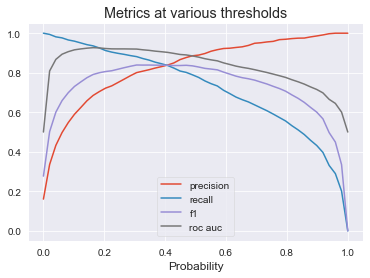

In [75]:
xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = threshhold_and_plot(y_train_xgb,y_proba_xgb)

In [76]:
xgb_thresh_idx, xgb_max_score = max_thresh(xgb_roc_auc)
print(f'max_roc_auc is: {xgb_max_score}')

max_roc_auc is: 0.9267709537507208


### Apply threshold on train set

In [77]:
xgb_train_labels = np.where(y_proba_xgb >= xgb_max_score, 1, 0)

In [78]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_train,lg_train_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

classification report
               precision    recall  f1-score   support

     Staying       0.89      1.00      0.94      5949
    Attrited       0.99      0.37      0.54      1139

    accuracy                           0.90      7088
   macro avg       0.94      0.68      0.74      7088
weighted avg       0.91      0.90      0.88      7088



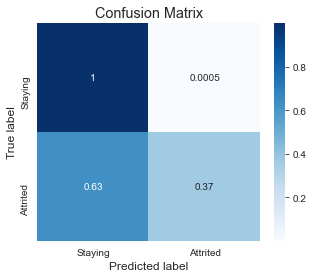

In [79]:
plot_Confusionmatrix(y_train,xgb_train_labels)
y_class_report = metrics.classification_report(y_train_xgb,xgb_train_labels,zero_division=1, target_names=["Staying","Attrited"])
print("classification report\n", y_class_report )

### Apply threshold on test set

In [80]:
xgb_test_predict = xgb_best_estimator.predict_proba(X_test_xgb)

In [81]:
xgb_test_labels = np.where(xgb_test_predict[:,1] >= xgb_max_score, 1, 0)

In [82]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_test,lg_test_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

classification report
               precision    recall  f1-score   support

     Staying       0.89      1.00      0.94      2551
    Attrited       0.95      0.37      0.54       488

    accuracy                           0.90      3039
   macro avg       0.92      0.68      0.74      3039
weighted avg       0.90      0.90      0.88      3039



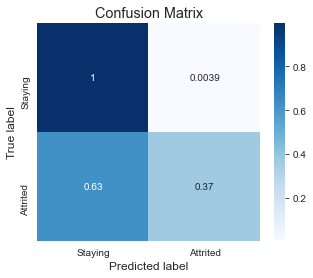

In [83]:
plot_Confusionmatrix(y_test_xgb,xgb_test_labels)
y_class_report = metrics.classification_report(y_test_xgb,xgb_test_labels,zero_division=1, target_names=["Staying","Attrited"])
print("classification report\n", y_class_report )

### Evaluation

This is generalized better compared to all modeland performed fairly well, as false -ve rate is 0.7 compared with logistic and random forest on both on train and test set. And I can see true +ve rate stayed 1, with recall 1 and improved precision 88%.generalized. This brings a model that can fairly make mistakes in unseen data, in comparison to other models.

### ROC_AUC Curve Comparison

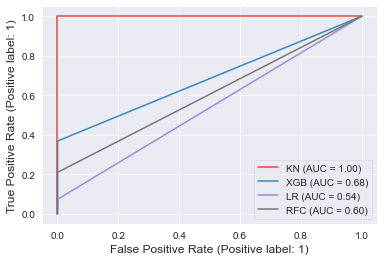

In [84]:
#on Train set
fig = metrics.RocCurveDisplay.from_predictions(y_train_knn, knn_train_labels,name='KN')
fig = metrics.RocCurveDisplay.from_predictions(y_train_xgb, xgb_train_labels, ax = fig.ax_,name='XGB')
fig = metrics.RocCurveDisplay.from_predictions(y_train_lg, lg_train_labels, ax = fig.ax_,name='LR')
fig = metrics.RocCurveDisplay.from_predictions(y_train_rfc, rfc_train_labels, ax = fig.ax_,name='RFC')
plt.show()

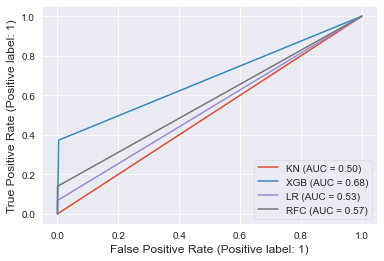

In [85]:
#on test set
fig = metrics.RocCurveDisplay.from_predictions(y_test_knn, knn_test_labels,name='KN')
fig = metrics.RocCurveDisplay.from_predictions(y_test_xgb, xgb_test_labels, ax = fig.ax_,name='XGB')
fig = metrics.RocCurveDisplay.from_predictions(y_test_lg, lg_test_labels, ax = fig.ax_,name='LR')
fig = metrics.RocCurveDisplay.from_predictions(y_test_rfc, rfc_test_labels, ax = fig.ax_,name='RFC')
plt.show()

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

When AUC = 1, then the classifier is able to perfectly identified between all the Positive and the Negative class points correctly. If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.

When 0.5<AUC<1, there is a high chance that the classifier will be able to identify the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.

When AUC=0.5, then the classifier is not able to identify between Positive and Negative class points.

On comparing train and test roc_curves -
* Logistic regression is performing well on both training and test set. With score 0.55 This is generalized better.

* KNeighbors performed very badly on train is 1.0 and on test data with roc_auc 0.71. It is overfitting.Meaning it can  perfectly identify between all the Positive and the Negative class points correctly on train set.However on test data there is a chance KN identify the defaults from the non-defaults class values

* RandomForest has both train and test roc_auc is 0.5. It is same as naive. Model does not have ability to predicts defaults and non-defaults.

* XGboost has done fairly well to interms of roc_auc performance with slight difference between train and test roc_auc, those are 0.64 and .64.scores are almost close.Same as Logistic regression, generalized better.


XBBoost is generalized better, followed with logistic regression.KNeighbor performed poorly. Rondoam Forest is same as naive model.

With this it can be concluded XGBoost can performing fairly well among all selected model on these kind of data.so it is safe to select XGB classifier for further steps.

## Summary

* XGBoost and Logistic regression is performing well on both training and test set.
* RandomForest is the same as naive. Model does not have the ability to predict defaults and non-defaults.
* KNeighbors is overfitting

### Improvemments <a id=AdditionalModels></a>

* XGbooost performed best with 0.99 and 0.96 on train and unseen data set,and interms on improving true +ves and False-ves and with stable true -ve. This shows model can predict majority classes correctly. 
* Logistic Regression performed well on both train and test set, with roc_auc staying stable at 0.81 and 0.82, model has ability to find majority classes and poor on minority class.
* However all the four models have enough abilities to predict majoroty classes on unseen data, and this is confirmed with true -ve rate staying stable across all model. However models have not enough ability to predict minority classes both on train and unseen set, as this is visible with False -ve rate is outstanding.
* This shows all of these models can predict customer is existing, however customer leaves the bank. This is the potential concern, I still need to address the concern.

I can try using pr_auc metrics, as I am more interested in optimizing recall.Rather using roc_auc where it optimizes true +ves and false +ves. should try tuning model on both Grid and Random search. 

I may go back and revisit my scaling in EDA and visualize data differently and get the best scaled output.

Train the model with bigger dataset, so that it can learn the more on False -ve cases.

I used roc_auc is scoring, as it is tpr vs fpr,all  models stayed stable for True+ve and controlled on False +ve cases. I may need to see is there a hybrid pattern of scoring or may be used 'f1' score.

### Additional Models

I have selected four of the many machine learning models available. 

- It would be interesting to see the results of other models, meaning trying different alogorithms
- making combination or hybrid models, e.g. RF + TensorFlow
- try feature crosses like dmatrix from patsy
- clustering or association rules.


## Recommendations <a id = Recom></a>